<a href="https://colab.research.google.com/github/gauravshetty98/Gaurav-GIS-Repo/blob/main/map_ps0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizing state wise substance use and its correlation with other factors

In this project I try to find a corelation if any exists between the intake of drugs and other factors like mental health.

I am making use of SAMHSA 2021 NSDUH: state specific tables for this project. It is a dataset which contains PDFs containing drug intake data along with mental health data for each state.

Dataset link: https://www.samhsa.gov/data/report/2021-nsduh-state-specific-tables

The code for data extraction from these PDFs is already present in the Github repository.

------------

### Importing Python Libraries

aok: cool; just also make maps per capita, ie divide drugs by population--ie CA and TX have many people so there will be lots of drugs because there are many people, but doesnt mean that there is more drug problem than elsewhere

In [2]:
import os, zipfile
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
#! pip install geopandas
!pip install mapclassify
import geopandas as gpd
import mapclassify
import mpl_toolkits
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
from shapely.geometry import Point, Polygon
import seaborn as sb


#will display all output not just last command
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from google.colab import data_table
data_table.enable_dataframe_formatter() #this enables spreadsheet view upon calling dataframe (without() )

## Mapping geographic map of USA

Since we are using data specific to the states of USA, we will be plotting a USA shape file.

In the code below, we first download the zip file from the internet. We then extract the zip file and search for USA shape file. Once found, we assign it to a variable and plot it.

In [40]:
! wget -q -O States_shapefile.zip https://github.com/gauravshetty98/Gaurav-GIS-Repo/raw/main/States_shapefile.zip

zip_ref = zipfile.ZipFile('States_shapefile.zip', 'r');
zip_ref.extractall();
zip_ref.close() #just unzipping
usa_shp = gpd.read_file('States_shapefile.shp') #load the shapefile with gpd as njC

In [41]:
#usa_shp.plot()

We will not be looking into the statistics of ALASKA and HAWAI in this project hence dropping both the states from the shape file.

In [42]:
usa_shp = usa_shp.drop([1])
usa_shp = usa_shp.drop([11])

The shape file of USA mainland which we will be using in this project:

<Axes: >

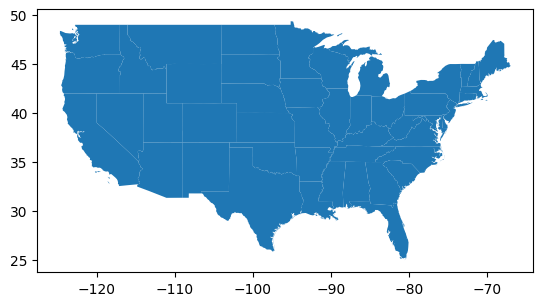

In [43]:
usa_shp.plot()

## Other Information from the shape file

Here we check the different datatypes and columns present in the shape file

In [44]:
usa_shp.dtypes #with geopandas can do stuff like with pandas :)

FID              int64
Program         object
State_Code      object
State_Name      object
Flowing_St      object
FID_1            int64
geometry      geometry
dtype: object

In [45]:
usa_shp.columns

Index(['FID', 'Program', 'State_Code', 'State_Name', 'Flowing_St', 'FID_1',
       'geometry'],
      dtype='object')

## Importing Drug Abuse and Mental Health Dataset

Here we import the drug use and mental health data extracted from NSDUH. We are importing this file from GitHub using `!wget`.

Dataset link: https://www.samhsa.gov/data/report/2021-nsduh-estimated-totals-state

In [46]:
! wget https://github.com/gauravshetty98/Gaurav-GIS-Repo/raw/main/state_dataset.csv

--2023-11-06 04:31:41--  https://github.com/gauravshetty98/Gaurav-GIS-Repo/raw/main/state_dataset.csv
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gauravshetty98/Gaurav-GIS-Repo/main/state_dataset.csv [following]
--2023-11-06 04:31:42--  https://raw.githubusercontent.com/gauravshetty98/Gaurav-GIS-Repo/main/state_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168993 (165K) [text/plain]
Saving to: ‘state_dataset.csv.1’

state_dataset.csv.1 100%[===================>] 165.03K  --.-KB/s    in 0.02s   

2023-11-06 04:31:42 (6.50 MB/s) - ‘state_dataset.csv.1’ saved [168993/168993]



In [47]:
dataset = pd.read_csv("state_dataset.csv")
dataset.head()

,index,Measure,12+,12-17,18-25,26+,18+,states
0,1,ILLICIT DRUGS Illicit Drug Use in the Past Mon...,403,17,98,288,386,Alabama
1,2,Marijuana Use in the Past Year,537,30,152,355,507,Alabama
2,3,Marijuana Use in the Past Month,315,16,90,209,299,Alabama
3,4,Perceptions of Great Risk from Smoking Marijua...,"1,128",105,83,940,"1,023",Alabama
4,6,First Use of Marijuana in the Past Year among ...,40,15,20,6,25,Alabama


### Making both DataFrames inline with each other

To make the merging easy, we change the state names to upper case and remove any spaces present in them.

We also change the Column name so that both dataframes have the same column names for states.

We also change the value for "District Of Columbia" so that both dataframes are inline with each other

In [48]:
dataset['states'] = dataset['states'].str.upper()

In [49]:
usa_shp['State_Name'] = usa_shp['State_Name'].str.replace(' ', '')

In [50]:
dataset = dataset.rename(columns = {'states':'State_Name'})
dataset['State_Name'] = dataset['State_Name'].replace('DISTRICTOFCOL','DISTRICTOFCOLUMBIA')
dataset.columns

Index(['index', 'Measure', '12+', '12-17', '18-25', '26+', '18+',
       'State_Name'],
      dtype='object')

### Merging both the datasets

We have created two different datasets which have the complete information using inner and outer join.

We are not using these datasets at the moment, these are only for knowledge purpose.

In [51]:
complete_df_outer = pd.merge(usa_shp, dataset, on = 'State_Name', how = 'outer', indicator = True)
complete_df_outer.to_csv("dataset_merged_outer.csv")

In [52]:
complete_df_inner = pd.merge(usa_shp, dataset, on = 'State_Name', how = 'inner', indicator = True)
complete_df_inner.to_csv("dataset_merged_inner.csv")

## Mapping some preliminary maps

### Mapping Total Count Of Drug Usage in USA

We start of with creating a dataframe which contains quantitative data about the amount of illicit drugs being consumed in USA.

Note this plot does not take into account the population of each state

In [53]:
illicit_drug_df = pd.DataFrame(columns = dataset.columns)
for i in range(0,dataset.shape[0]):
  if dataset.iloc[i,1] == "ILLICIT DRUGS Illicit Drug Use in the Past Month1,2":
    illicit_drug_df.loc[len(illicit_drug_df.index)] = dataset.loc[i,:]
#print(illicit_drug_df.head())

Here we merge the new dataframe with the geopanda dataframe usa_shp

In [54]:
drug_map = pd.merge(usa_shp, illicit_drug_df, on = 'State_Name', how = 'inner', indicator = False)

During reading the CSV file some columns were read as strings. We cant plot properly with string values. Here we convert these strings to integer datatype using `to_numeric()` function

In [55]:
drug_map['18+'] = drug_map['18+'].str.replace(",","")
drug_map['18+'] = pd.to_numeric(drug_map['18+'])

We have created a plot of State wise usage of Illicit Drugs.

All numbers are in thousands

<Axes: >

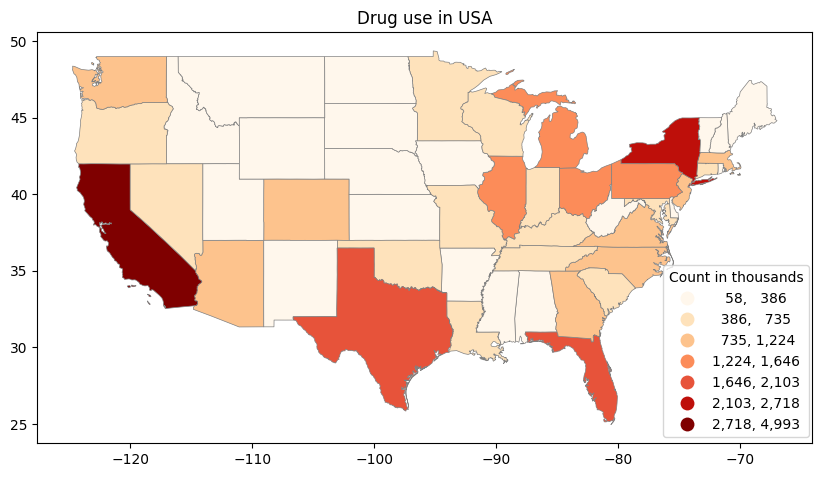

In [56]:
fig, ax = plt.subplots(1, figsize=(10,12))
drug_map.plot(ax= ax,column='18+',legend=True,cmap='OrRd',scheme='natural_breaks',k=7, edgecolor='grey',
              linewidth=0.5,legend_kwds= {'bbox_to_anchor': (1.005, 0.45),"fmt": "{:,.0f}"})
ax.title.set_text('Drug use in USA')
leg_drug = ax.get_legend()
leg_drug.set_title('Count in thousands')

### Mapping Total Count Of Alcohol use in USA

We follow the same steps and try to produce a heatmap for Alcohol use in USA.

Note this plot does not take into account the population in each state.

In [57]:
alcohol_df = pd.DataFrame(columns = dataset.columns)
for i in range(0,dataset.shape[0]):
  if dataset.iloc[i,1] == "ALCOHOL Alcohol Use in the Past Month":
    alcohol_df.loc[len(alcohol_df.index)] = dataset.loc[i,:]
#print(alcohol_df.head())

In [58]:
alcohol_df['18+'] = alcohol_df['18+'].str.replace(",","")
alcohol_df['18+'] = pd.to_numeric(alcohol_df['18+'])
alcohol_map = pd.merge(usa_shp, alcohol_df, on = 'State_Name', how = 'inner', indicator = False)

<Axes: >

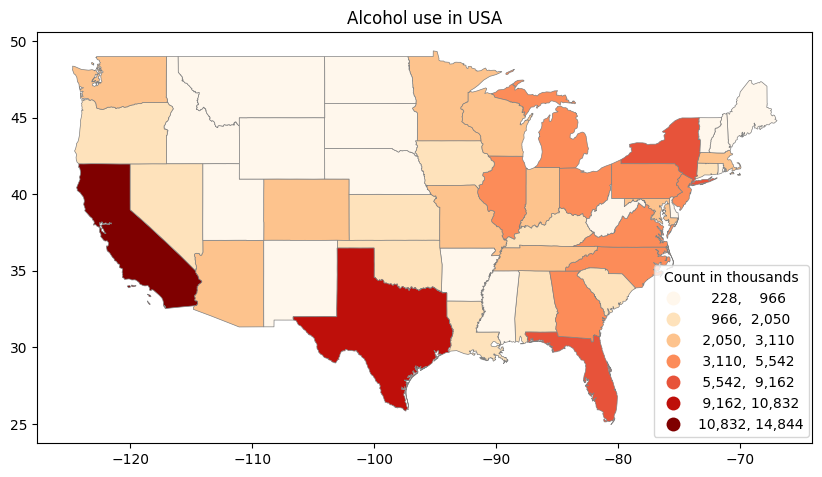

In [59]:
fig, ax = plt.subplots(1, figsize=(10,12))
alcohol_map.plot(ax = ax,column='18+',legend=True,cmap='OrRd',scheme='natural_breaks',k=7, edgecolor='grey',
              linewidth=0.5,legend_kwds= {'bbox_to_anchor': (1.005, 0.45),"fmt": "{:,.0f}"})
ax.title.set_text('Alcohol use in USA')
leg_alc = ax.get_legend()
leg_alc.set_title('Count in thousands')

### Mapping Total Count Of Reported Mental Health Issues in USA

We follow the same steps to create a heatmap for the mental health issues being reported in USA

Note this plot does not take into account the population in each state

In [60]:
mental_health_df = pd.DataFrame(columns = dataset.columns)
for i in range(0,dataset.shape[0]):
  if dataset.iloc[i,1] == "MENTAL HEALTH MEASURES IN THE PAST YEAR Any Mental Illness4,10":
    mental_health_df.loc[len(mental_health_df.index)] = dataset.loc[i,:]
#print(mental_health_df.head())

In [61]:
mental_health_df['18+'] = mental_health_df['18+'].str.replace(",","")
mental_health_df['18+'] = pd.to_numeric(mental_health_df['18+'])
mental_health_map = pd.merge(usa_shp, mental_health_df, on = 'State_Name', how = 'inner', indicator = False)

<Axes: >

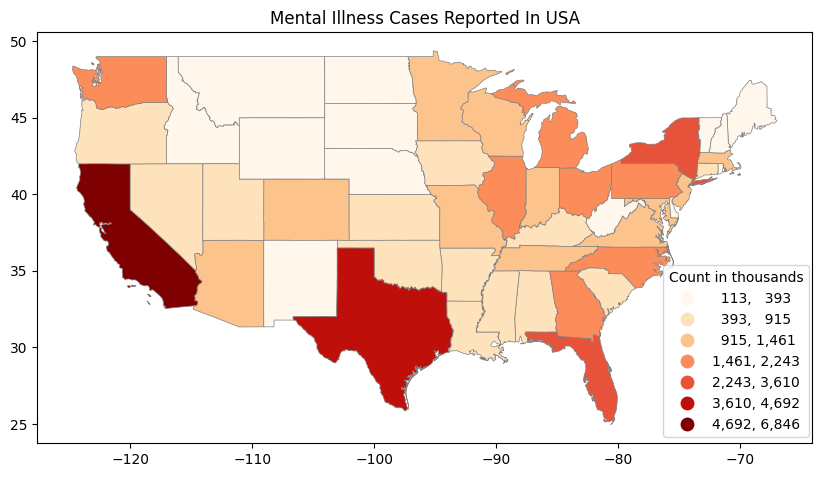

In [115]:
fig, ax = plt.subplots(1, figsize=(10,12))
mental_health_map.plot(ax = ax,column='18+',legend=True,cmap='OrRd',scheme='natural_breaks',k=7, edgecolor='grey',
              linewidth=0.5,legend_kwds= {'bbox_to_anchor': (1.005, 0.45),"fmt": "{:,.0f}"})
ax.title.set_text('Mental Illness Cases Reported In USA')
leg_mental = ax.get_legend()
leg_mental.set_title('Count in thousands')

### Mapping Total Count Of Reported Suicide Attempts in USA

We follow the same steps to create a heatmap for the suicide attempts being reported in USA

Note this plot does not take into account the population in each state

In [112]:
suicide_df = pd.DataFrame(columns = dataset.columns)
for i in range(0,dataset.shape[0]):
  if dataset.iloc[i,1] == "Attempted Suicide":
    suicide_df.loc[len(suicide_df.index)] = dataset.loc[i,:]
#print(mental_health_df.head())

In [113]:
suicide_df['18+'] = suicide_df['18+'].str.replace(",","")
suicide_df['18+'] = pd.to_numeric(suicide_df['18+'])
suicide_map = pd.merge(usa_shp, suicide_df, on = 'State_Name', how = 'inner', indicator = False)

<Axes: >

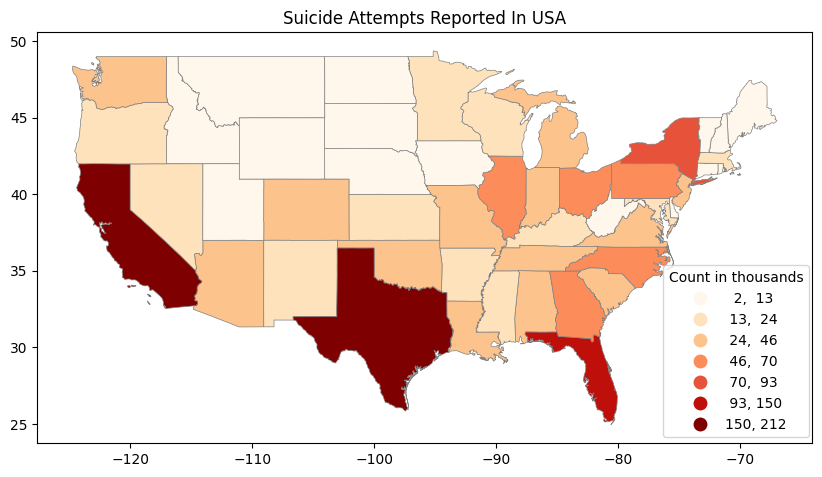

In [114]:
fig, ax = plt.subplots(1, figsize=(10,12))
suicide_map.plot(ax = ax,column='18+',legend=True,cmap='OrRd',scheme='natural_breaks',k=7, edgecolor='grey',
              linewidth=0.5,legend_kwds= {'bbox_to_anchor': (1.005, 0.45),"fmt": "{:,.0f}"})
ax.title.set_text('Suicide Attempts Reported In USA')
leg_suicide = ax.get_legend()
leg_suicide.set_title('Count in thousands')

## Mapping Total Count Against State Population

We have mapped the amount of drugs being consumed in each state but we havent taken into consideration the population of each state. If we do not take the population of each state into consideration, these statistics can be a bit misleading.  

Dataset link: [Census Dataset](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjb16v2jLyBAxXbLzQIHSkFCrEQFnoECA4QAQ&url=https%3A%2F%2Fwww2.census.gov%2Fprograms-surveys%2Fpopest%2Ftables%2F2020-2022%2Fstate%2Fdetail%2FSCPRC-EST2022-18%2BPOP.xlsx&usg=AOvVaw1S9qPNFScgzhEtl1ADZne5&opi=89978449)

We start of importing the CENSUS estimates for population of each state for the age of 18 and above.

In [63]:
!wget -O population_data https://github.com/gauravshetty98/Gaurav-GIS-Repo/raw/main/SCPRC-EST2022-18%2BPOP.xlsx

--2023-11-06 04:31:47--  https://github.com/gauravshetty98/Gaurav-GIS-Repo/raw/main/SCPRC-EST2022-18%2BPOP.xlsx
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gauravshetty98/Gaurav-GIS-Repo/main/SCPRC-EST2022-18%2BPOP.xlsx [following]
--2023-11-06 04:31:47--  https://raw.githubusercontent.com/gauravshetty98/Gaurav-GIS-Repo/main/SCPRC-EST2022-18%2BPOP.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14025 (14K) [application/octet-stream]
Saving to: ‘population_data’

population_data     100%[===================>]  13.70K  --.-KB/s    in 0.001s  

2023-11-06 04:31:48 (23.5 MB/s) - ‘population

In [64]:
population =  pd.read_excel('population_data')
population.head(10)

,table with row headers in column A and column headers in rows 3 through 4. (leading dots indicate sub-parts),Unnamed: 1,Unnamed: 2,Unnamed: 3
0,Estimates of the Total Resident Population and...,NaN,NaN,NaN
1,Geographic Area,Total Resident\nPopulation,Resident Population Age 18\n Years and Older,NaN
2,NaN,NaN,Number,Percent
3,United States,333287557,260836730,78.3
4,Northeast,57040406,45544589,79.8
5,Midwest,68787595,53626659,78
6,South,128716192,100098310,77.8
7,West,78743364,61567172,78.2
8,.Alabama,5074296,3962734,78.1
9,.Alaska,733583,557060,75.9


In [65]:
population.iloc[:,0] = population.iloc[:,0].str.upper()
population.iloc[:,0] = population.iloc[:,0].str.replace(".","")
population = population.iloc[8:59,0:3]
#population.head(10)

<ipython-input-65-ea3d0d3dce4e>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  population.iloc[:,0] = population.iloc[:,0].str.replace(".","")


In [66]:
population = population.rename(columns = {'table with row headers in column A and column headers in rows 3 through 4. (leading dots indicate sub-parts)':'State_Name', 'Unnamed: 1':'Total Population', 'Unnamed: 2':'Above 18'})
population['State_Name'] = population['State_Name'].str.replace(' ', '')
population.columns

Index(['State_Name', 'Total Population', 'Above 18'], dtype='object')

In [67]:
usa_shp_pop_outer = pd.merge(usa_shp, population, on = 'State_Name', how = 'outer', indicator = 'exists')
usa_shp_pop_outer.to_csv("usa_shp_outer_with_population.csv")

usa_shp_pop_inner = pd.merge(usa_shp, population, on = 'State_Name', how = 'inner', indicator = 'exists')
usa_shp_pop_inner.to_csv("usa_shp_inner_with_population.csv")

Here we plot the population of USA to get an idea of population in each state which makes it easier for us to compare

<Axes: >

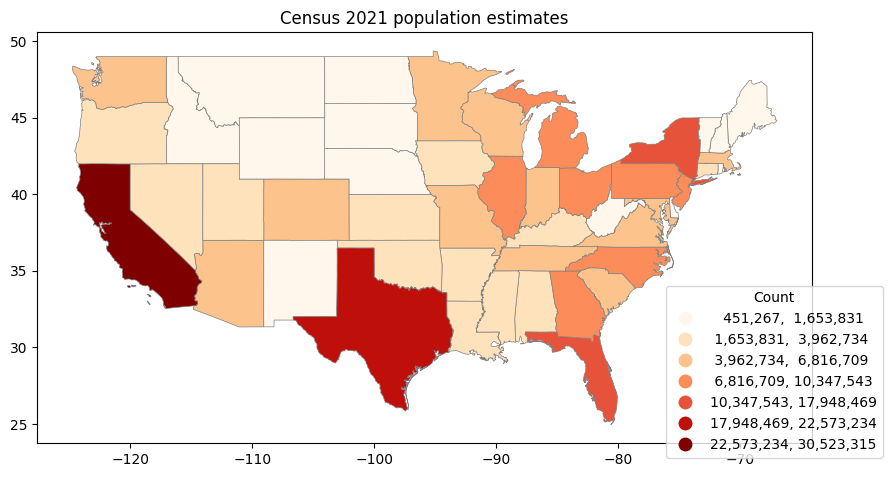

In [68]:
fig, ax = plt.subplots(1, figsize=(10,12))
usa_shp_pop_inner.plot(ax = ax,column='Above 18',legend=True,cmap='OrRd',scheme='natural_breaks',k=7, edgecolor='grey',
              linewidth=0.5,legend_kwds= {'bbox_to_anchor': (1.1, 0.4),"fmt": "{:,.0f}"})
ax.title.set_text('Census 2021 population estimates')
leg_pop = ax.get_legend()
leg_pop.set_title('Count')

### Proportion of people using drugs in each state

Here we have divided the drug use count of each state by its population to get a rough estimate of the percentage of people consuming illicit drugs

In [69]:
drug_map['Pop_based_count'] = 0
for i in range(0,drug_map.shape[0]):
  drug_map.iloc[i,14] = ((drug_map.iloc[i,13]*1000) / usa_shp_pop_inner.iloc[i,8])*100


<Axes: >

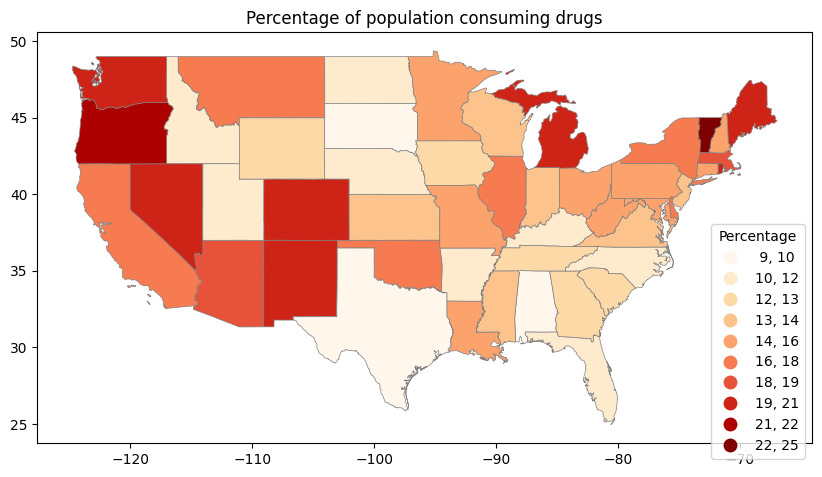

In [70]:
fig, ax = plt.subplots(1, figsize=(10,12))
drug_map.plot(ax = ax,column='Pop_based_count',legend=True,cmap='OrRd',scheme='natural_breaks',k=10, edgecolor='grey',
              linewidth=0.5,legend_kwds= {'bbox_to_anchor': (1, 0.55),"fmt": "{:,.0f}"})
ax.title.set_text('Percentage of population consuming drugs')
leg_pop = ax.get_legend()
leg_pop.set_title('Percentage')


### Proportion of people using alcohol in each state

Here we have divided the alcohol consumption in each state by its population to give a rough estimate about the percentage of population consuming alcohol

In [71]:
alcohol_map['Pop_based_count'] = 0
for i in range(0,alcohol_map.shape[0]):
  alcohol_map.iloc[i,14] = ((alcohol_map.iloc[i,13]*1000) / usa_shp_pop_inner.iloc[i,8])*100

<Axes: >

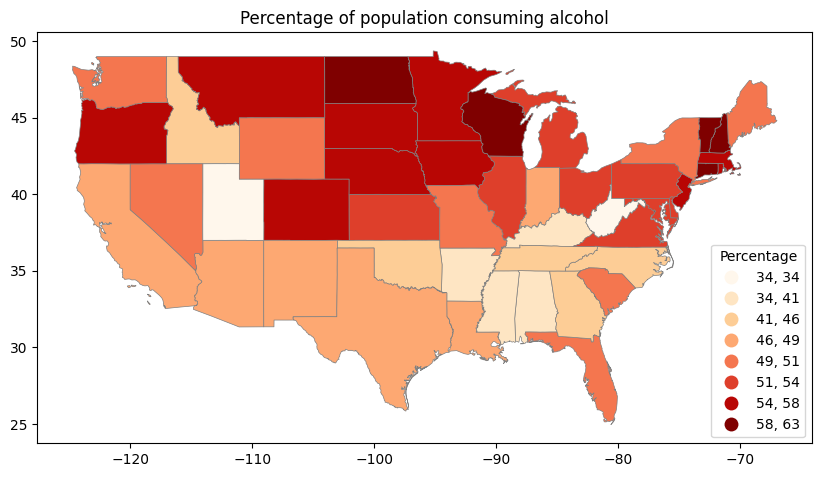

In [72]:
fig, ax = plt.subplots(1, figsize=(10,12))
alcohol_map.plot(ax = ax,column='Pop_based_count',legend=True,cmap='OrRd',scheme='natural_breaks',k=8, edgecolor='grey',
              linewidth=0.5,legend_kwds= {'bbox_to_anchor': (1, 0.5),"fmt": "{:,.0f}"})
ax.title.set_text('Percentage of population consuming alcohol')
leg_pop = ax.get_legend()
leg_pop.set_title('Percentage')

### Proportion of people with mental health issues

Here we have divided the Mental Health  in each state by its population to give a rough estimate about the percentage

In [73]:
mental_health_map['Pop_based_count'] = 0
for i in range(0,mental_health_map.shape[0]):
  mental_health_map.iloc[i,14] = ((mental_health_map.iloc[i,13]*1000) / usa_shp_pop_inner.iloc[i,8])*100

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,12))
mental_health_map.plot(ax = ax,column='Pop_based_count',legend=True,cmap='OrRd',scheme='natural_breaks',k=8, edgecolor='grey',
              linewidth=0.5,legend_kwds= {'bbox_to_anchor': (1, 0.5),"fmt": "{:,.0f}"})
ax.title.set_text('Percentage of population having reported any mental illness')
leg_pop = ax.get_legend()
leg_pop.set_title('Percentage')

### Percentage of suicide attempts based on population

Here we have divided the reported suicide attempts in each state by its population to give a rough estimate about the percentage

In [116]:
suicide_map['Pop_based_count'] = 0
for i in range(0,suicide_map.shape[0]):
  suicide_map.iloc[i,14] = ((suicide_map.iloc[i,13]*1000) / usa_shp_pop_inner.iloc[i,8])*100

<Axes: >

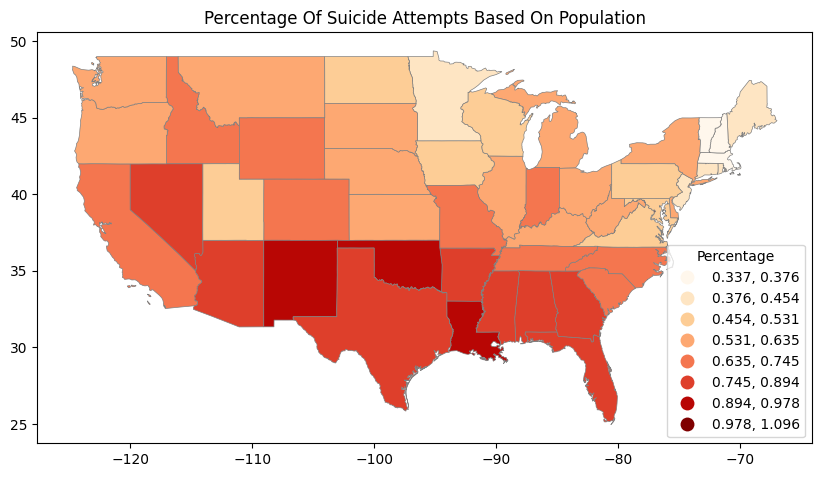

In [120]:
fig, ax = plt.subplots(1, figsize=(10,12))
suicide_map.plot(ax = ax,column='Pop_based_count',legend=True,cmap='OrRd',scheme='natural_breaks',k=8, edgecolor='grey',
              linewidth=0.5,legend_kwds= {'bbox_to_anchor': (1, 0.5),"fmt": "{:,.3f}"})
ax.title.set_text('Percentage Of Suicide Attempts Based On Population')
leg_pop = ax.get_legend()
leg_pop.set_title('Percentage')

## Trying to find a corelation between Crime, Drug Use, Alcohol Use and Mental Health

We make use of State wise crime data published by the Federal Bureau of Investigation. We found this dataset in the FBI's Crime Data Explorer.

Dataset link: https://cde.ucr.cjis.gov/LATEST/webapp/#/pages/downloads

We have three different excels which we need to merge and create one single dataframe.

In [21]:
!wget https://github.com/gauravshetty98/Gaurav-GIS-Repo/raw/main/Crimes_Against_Persons_Offenses_Offense_Category_by_State_2021.xlsx
!wget https://github.com/gauravshetty98/Gaurav-GIS-Repo/raw/main/Crimes_Against_Property_Offenses_Offense_Category_by_State_2021.xlsx
!wget https://github.com/gauravshetty98/Gaurav-GIS-Repo/raw/main/Crimes_Against_Society_Offenses_Offense_Category_by_State_2021.xlsx

--2023-11-06 04:29:15--  https://github.com/gauravshetty98/Gaurav-GIS-Repo/raw/main/Crimes_Against_Persons_Offenses_Offense_Category_by_State_2021.xlsx
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gauravshetty98/Gaurav-GIS-Repo/main/Crimes_Against_Persons_Offenses_Offense_Category_by_State_2021.xlsx [following]
--2023-11-06 04:29:15--  https://raw.githubusercontent.com/gauravshetty98/Gaurav-GIS-Repo/main/Crimes_Against_Persons_Offenses_Offense_Category_by_State_2021.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22257 (22K) [application/octet-stream]
Saving to: ‘Crimes_Against_Persons_O

In [22]:
crime_against_person = pd.read_excel("Crimes_Against_Persons_Offenses_Offense_Category_by_State_2021.xlsx",skiprows = [0,1,2,3])
crime_against_property = pd.read_excel("Crimes_Against_Property_Offenses_Offense_Category_by_State_2021.xlsx",skiprows = [0,1,2,3])
crime_against_society = pd.read_excel("Crimes_Against_Society_Offenses_Offense_Category_by_State_2021.xlsx",skiprows = [0,1,2,3])

Here you can see the three different datasets that I have imported

The crimes are divided into three different categories: crime against person, crime against property and crime against society.
Each category has its own CSV with much more details but, we will only be using the total count of each of these categories.

In [23]:
crime_against_person.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Total\nOffenses,Offense Category,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,State,Number\nof Participating\nAgencies,Population\nCovered,NaN,Assault\nOffenses,Homicide\nOffenses,Human\nTrafficking\nOffenses,Kidnapping/\nAbduction,Sex\nOffenses
1,Total,11794,215058917,2939412.0,2706772,16537,2141,36919,177043
2,Alabama,356,3734077,70855.0,68366,381,18,388,1702
3,Alaska,30,402557,6858.0,5945,31,2,29,851
4,Arizona,79,3949562,45372.0,40946,235,7,706,3478


In [24]:
crime_against_person.iloc[0,3] = "Total Offenses Against Person"
crime_against_person.columns = crime_against_person.iloc[0,:]
crime_against_person = crime_against_person.iloc[1:,:4]
#crime_against_person.head()

In [25]:
crime_against_property.iloc[0,3] = "Total Offenses Against Property"
crime_against_property.columns = crime_against_property.iloc[0,:]
crime_against_property = crime_against_property.iloc[1:,:4]
#crime_against_property.head()

In [26]:
crime_against_society.iloc[0,3] = "Total Offenses Against Society"
crime_against_society.columns = crime_against_society.iloc[0,:]
crime_against_society = crime_against_society.iloc[1:,:4]
#crime_against_society.head()

### Calculating and plotting the Crime Rate in different states

Creating a single dataset for all the state wise crime data by merging the different dataframes into a single one

In [75]:
inter_df = pd.merge(crime_against_person, crime_against_property, on = 'State', how = 'outer', indicator = True)
crime_dataset = pd.merge(crime_against_society, inter_df, on = 'State',how = 'outer', indicator = 'exsits')

In [76]:
crime_dataset.to_csv("crime_master_dataset.csv")
#crime_dataset.head()

In [77]:
crime_dataset = crime_dataset.drop(crime_dataset.columns[[4,5,7,8]], axis=1)
crime_dataset.head()

,State,Number of\nParticipating\nAgencies _x,Population\nCovered,Total Offenses Against Society,Total Offenses Against Person,Total Offenses Against Property,_merge,exsits
0,Total,11794,215058917,1620563.0,2939412.0,6531976.0,both,both
1,Alabama,356,3734077,30075.0,70855.0,122274.0,both,both
2,Alaska,30,402557,1730.0,6858.0,7301.0,both,both
3,Arizona,79,3949562,34213.0,45372.0,104648.0,both,both
4,Arkansas,285,2916168,38618.0,66379.0,123785.0,both,both


The dataset has its own estimates of population based on the agencies that have provided the data. We are using the population estimates in the census data percentages.

Also the agencies which provided data for Florida did not have population calculations.

In [78]:
crime_dataset.iloc[:,0] = crime_dataset.iloc[:,0].str.upper()
crime_dataset.iloc[:,0] = crime_dataset.iloc[:,0].str.replace(".","")
crime_dataset.iloc[:,0] = crime_dataset.iloc[:,0].str.replace("1","")
crime_dataset.iloc[:,0] = crime_dataset.iloc[:,0].str.replace(" ","")

<ipython-input-78-494eafd216d5>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  crime_dataset.iloc[:,0] = crime_dataset.iloc[:,0].str.replace(".","")


In [79]:
crime_dataset = crime_dataset.iloc[1:,:]

You can run the below code cell to see the difference between the population estimates by census and the population covered in the FBI dataset.

In [80]:
# for i in range(0,51):
#   if crime_dataset.iloc[i,0] ==  population.iloc[i,0]:
#     print("Crime:  ", crime_dataset.iloc[i,0],"Population: ", population.iloc[i,0], "Pop diff", (population.iloc[i,2] - crime_dataset.iloc[i,2]))

In [81]:
crime_dataset = crime_dataset.rename(columns = {'State':'State_Name'})

In [82]:
crime_dataset_pop = pd.merge(crime_dataset, population, on = 'State_Name',how = 'outer', indicator = 'exsits_1')
crime_dataset_pop.columns

Index(['State_Name', 'Number of\nParticipating\nAgencies _x',
       'Population\nCovered ', 'Total Offenses Against Society',
       'Total Offenses Against Person', 'Total Offenses Against Property',
       '_merge', 'exsits', 'Total Population', 'Above 18', 'exsits_1'],
      dtype='object')

#### Calculating Rate Of Crime In Each State Based On Population

Here we calculate the percentage of crime rate based on the population esitimates given by CENSUS.

These percentages are an underestimation of the actual crime rate as there are many agencies and population missing in the FBI dataset.

In [83]:
for a in range(0,crime_dataset_pop.shape[0]):
  for b in range(3, crime_dataset_pop.shape[1]-5):
    crime_dataset_pop.iloc[a,b] = round(((crime_dataset_pop.iloc[a,b])/(crime_dataset_pop.iloc[a,-2]))*100,2)
crime_dataset_pop.head()

,State_Name,Number of\nParticipating\nAgencies _x,Population\nCovered,Total Offenses Against Society,Total Offenses Against Person,Total Offenses Against Property,_merge,exsits,Total Population,Above 18,exsits_1
0,ALABAMA,356,3734077,0.76,1.79,3.09,both,both,5074296,3962734,both
1,ALASKA,30,402557,0.31,1.23,1.31,both,both,733583,557060,both
2,ARIZONA,79,3949562,0.59,0.79,1.81,both,both,7359197,5770187,both
3,ARKANSAS,285,2916168,1.64,2.83,5.27,both,both,3045637,2348518,both
4,CALIFORNIA,15,2861998,0.09,0.11,0.27,both,both,39029342,30523315,both


In [84]:
crime_dataset_pop.to_csv("crime_master_data_pop.csv")

In [85]:
crime_plot = pd.merge(usa_shp,crime_dataset_pop,on='State_Name',how='inner')
crime_plot.shape

(49, 17)

#### Ploting the Calculated Crime Rate Across USA

Here we plot three different plots for the three categories of offenses defined.

Text(0.5, 1.0, 'Offenses Against Society')

Text(0.5, 1.0, 'Offenses Against Person')

Text(0.5, 1.0, 'Offenses Against Property')

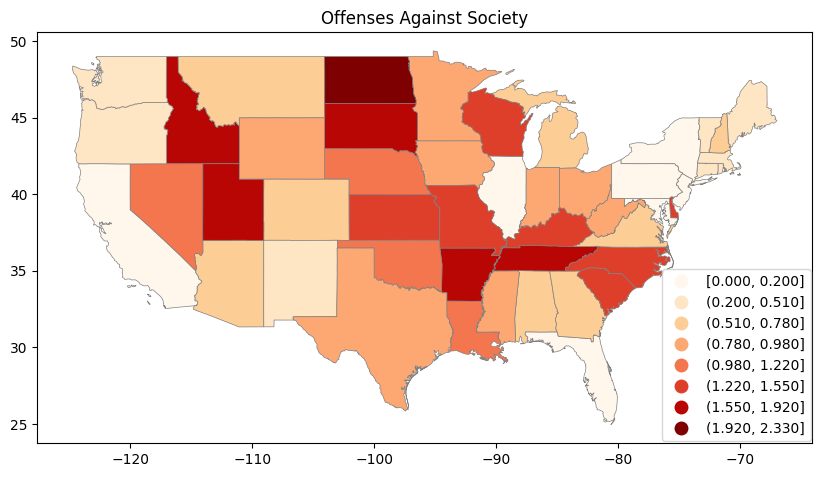

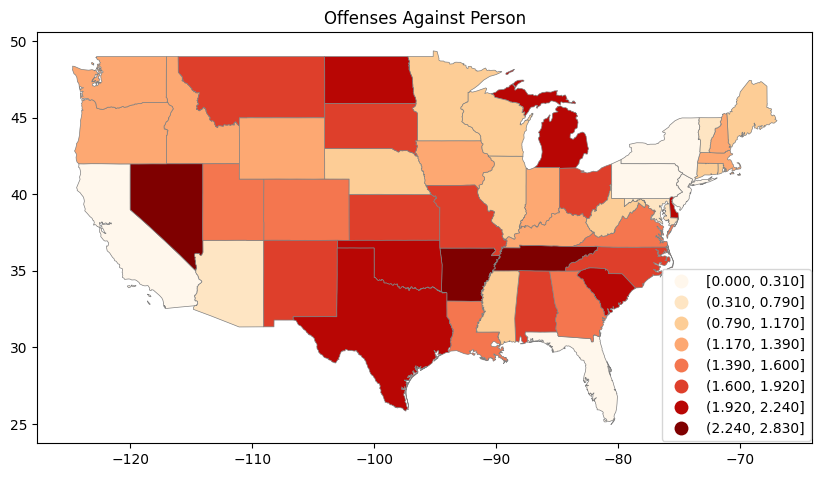

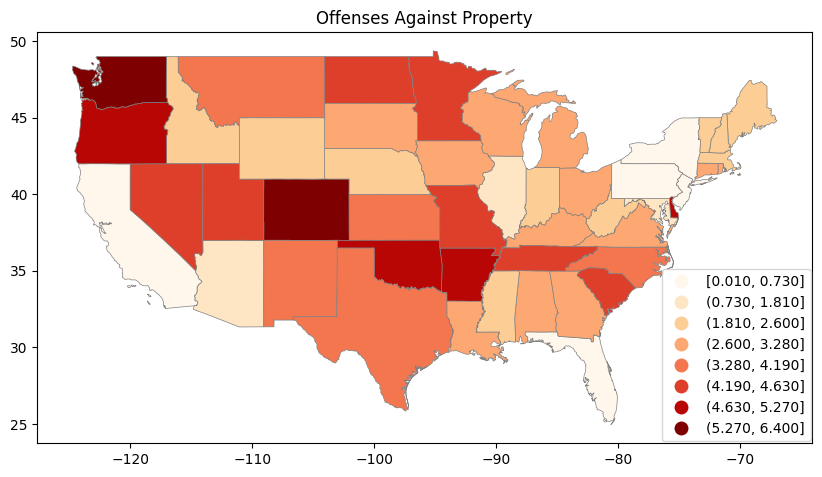

In [86]:
cps = crime_plot.plot(figsize=(10,12),column='Total Offenses Against Society',legend=True,cmap='OrRd',scheme='natural_breaks',k=8, edgecolor='grey',
              linewidth=0.5,legend_kwds= {'bbox_to_anchor': (1.007, 0.44),"fmt": "{:,.3f}", "interval": True})
cps.set_title("Offenses Against Society")

#Code for adding state wise annotations:
# for i in range(0,crime_plot.shape[0]):
#   x,y = crime_plot.geometry[i].representative_point().x, crime_plot.geometry[i].representative_point().y
#   label = crime_plot.State_Code[i]
#   cps.annotate(label, xy = (x,y), xytext = (-5,-5), textcoords = "offset points")

cpp = crime_plot.plot(figsize=(10,12),column='Total Offenses Against Person',legend=True,cmap='OrRd',scheme='natural_breaks',k=8, edgecolor='grey',
              linewidth=0.5,legend_kwds= {'bbox_to_anchor': (1.007, 0.44),"fmt": "{:,.3f}", "interval": True})
cpp.set_title("Offenses Against Person")

cppr = crime_plot.plot(figsize=(10,12),column='Total Offenses Against Property',legend=True,cmap='OrRd',scheme='natural_breaks',k=8, edgecolor='grey',
              linewidth=0.5,legend_kwds= {'bbox_to_anchor': (1.007, 0.44),"fmt": "{:,.3f}", "interval": True})
cppr.set_title("Offenses Against Property")

plt.show()

### Plotting the correlation matrix to gain insights

In this section I try to find the correlation between different substance use and crime rate. We create a master dataframe which contains all the variables being used in this project.

I plot a matrix scatterplot to find if there is any correlation between the variables we have picked so far.

In [121]:
master_df = pd.DataFrame(columns = ['State','A18+','D18+','MH18+','CAPrsn','CAS','CAProp'])
master_df['State'] = alcohol_map['State_Name']
master_df['A18+'] = alcohol_map['Pop_based_count']
master_df['D18+'] = drug_map['Pop_based_count']
master_df['MH18+'] = mental_health_map['Pop_based_count']
master_df['S18+'] = suicide_map['Pop_based_count']
master_df['CAPrsn'] = crime_plot['Total Offenses Against Person']
master_df['CAS'] = crime_plot['Total Offenses Against Society']
master_df['CAProp'] = crime_plot['Total Offenses Against Property']

In [122]:
cols = master_df.columns # Saving column names to a variable
master_df = master_df[cols].apply(pd.to_numeric, errors='coerce') # Converting the columns to numeric

<Axes: >

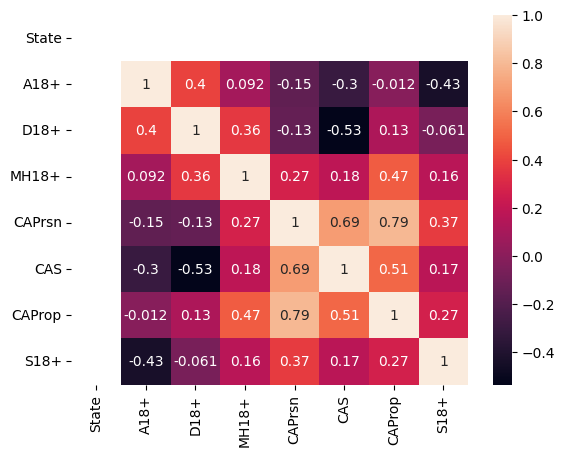

In [123]:
corr_matrix = master_df.corr(method = 'pearson')
sb.heatmap(corr_matrix, annot=True)
plt.show()

Here we can see a faint corelation between: <br>
i) Drug use and Crime against society <br>
ii) Alcohol use and Suicide attempts

Lets plot a scattterplot between these variables to get a better view

In [131]:
!pip install hvplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 8.5 MB/s eta 0:00:00


Text(0.5, 0, 'Drug use')

Text(0, 0.5, 'Crime against society')

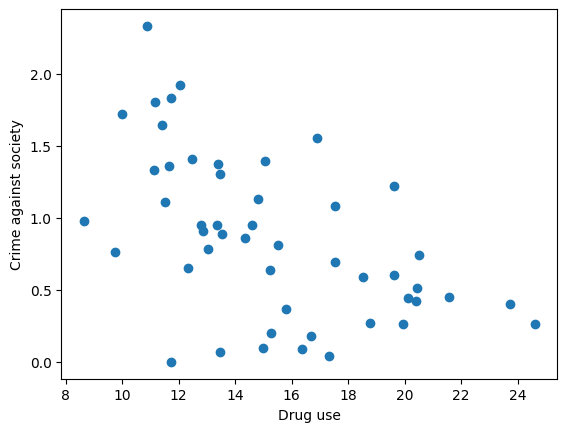

In [132]:
# fig = px.scatter_matrix(master_df[['D18+', 'CAS']])
# fig.show()
import hvplot.pandas


df.hvplot.scatter(x='sepal_length', y='sepal_width', by='species',
                  legend='top', height=400, width=400)

plt.scatter(master_df['D18+'], master_df['CAS'])
plt.xlabel('Drug use')
plt.ylabel('Crime against society')
plt.show()

As we can see in the scatterplots there are no major correlations between the variables that we have took so far. We cannot say thus far if there is any correlation between substance use and crime rates.

We will keep on adding variables in the matrix as we go along in the project

## Checking the treatment centres in each state for substance abuse and mental illness

We now import the dataset for rehab centres in usa. The main aim here is to check to if the states with high substance abuse rates have high rehab centres to tackle this problem.

We start with importing the dataset. The dataset contains many features defining each treatment centre in detail but we currently are only interested in the total number of centres.

In [ ]:
! wget -q -O rehab_data.csv https://github.com/gauravshetty98/Gaurav-GIS-Repo/raw/main/rehab_dataset.csv

rehab_df = pd.read_csv('rehab_data.csv')
rehab_df.head()

<ipython-input-56-4cd6c0daf7aa>:3: DtypeWarning:

Columns (10,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,165,166,167,168,169,170,172,202,205,206,209,213,214,215,216,217,218) have mixed types. Specify dtype option on import or set low_memory=False.



,Unnamed: 0,CASEID,STATE,STFIPS,DETOX,TREATMT,SMISEDSUD,OWNERSHP,FEDOWN,HOSPITAL,...,T_CLIML_D,T_CLIML_O,T_CLIML_X,T_CLIOP_D,T_CLIOP_O,T_CLIOP_X,T_CLIRC_D,T_CLIRC_O,T_CLIRC_X,Total Count
0,0,1,AK,2,0,1,1,6,3.0,0,...,NaN,NaN,1.0,NaN,NaN,4.0,NaN,NaN,NaN,105
1,1,2,AK,2,0,1,1,2,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,105
2,2,3,AK,2,1,1,0,2,NaN,0,...,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,105
3,3,4,AK,2,0,1,1,2,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,105
4,4,5,AK,2,1,1,0,2,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105


Here we create a new feature which stores the total count of substance abuse treatment centres in each state

In [ ]:
state = list(rehab_df['STATE'].unique())
count_df = pd.DataFrame(columns = ['State_Code', 'Count'])
for i in range(rehab_df.shape[0]):
  if rehab_df.iloc[i,2] in state:
    count_df.loc[len(count_df.index)] = [rehab_df.iloc[i,2], rehab_df.iloc[i,-1]]
    state.remove(rehab_df.iloc[i,2])

Merging the rehab dataset with alcohol consumption dataset

In [ ]:
ar_map = pd.merge(alcohol_map, count_df, on = 'State_Code', how = 'inner', indicator = False)

In [ ]:
ar_map.shape

(49, 16)

In [ ]:
#ar_map.head(1)

Creating a different dataframe with centroids for better visualization while plotting a geopandas plot

In [ ]:
rehabmap = ar_map[:]
rehabmap['geometry'] = rehabmap['geometry'].centroid

<ipython-input-61-a0444483f356>:2: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




### Map showing Alcohol count and rehab centres in each state

The following map shows the total alcohol count in each state visualized by a green gradient. It shows the total count and not the population percentage. The centroid dots is used to show the total count of treatment centres present in each state.

The central states show a low count of both alcohol and rehab centres. Where as states like california, texas and new york show a high count in both alcohol use and rehab centres.

In [ ]:
potrisk_map = ar_map.query("State_Code == 'TX'")

<Axes: >

<Axes: >

<Axes: >

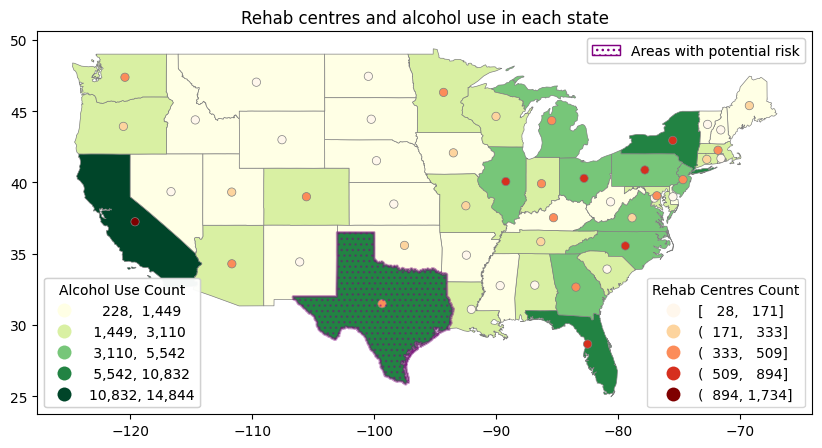

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,20))


ar_map.plot(ax= ax,column='18+',legend=True,cmap='YlGn',scheme='natural_breaks',k=5, edgecolor='grey',
              linewidth=0.5,legend_kwds= {"fmt": "{:,.0f}","loc":"lower left"})
l1 = ax.get_legend()
l1.set_title('Alcohol Use Count')
ax.add_artist(l1)

rehabmap.plot(ax = ax,column='Count',legend=True,cmap='OrRd',scheme='natural_breaks',k=5, edgecolor='grey',
             linewidth=0.5,legend_kwds= {"fmt": "{:,.0f}", "interval": True,"loc":"lower right"})
l2 = ax.get_legend()
l2.set_title('Rehab Centres Count')
ax.add_artist(l2)

potrisk_map.plot(ax = ax,edgecolor='purple',linewidth=2, facecolor="none",alpha=0.4,hatch='...')

potrisk_patch = mpatches.Patch(edgecolor='purple', facecolor='none',
                     hatch='...', label=r'Areas with potential risk')
l3=plt.legend(handles=[potrisk_patch],loc='upper right')

ax.title.set_text('Rehab centres and alcohol use in each state')

ax.add_artist(l1)
ax.add_artist(l3)

plt.show()


### Map showing percentage alcohol use and rehab centres in each state

The following map shows the percentage alcohol count in each state visualized by a green gradient. It shows the percentage population of each state who consume alcohol. States with dark green gradient have a higher percentage of population consuming alcohol which might be a problem. The centroid dots is used to show the total count of treatment centres present in each state.

Mostly the central and nothern states like Colorado, North Darkota, Nebrasaka have a high percentage of people consuming alcohol but, also these states have a low count of rehab centres.

In [ ]:
highrisk_map = ar_map.query("State_Code == 'ND' | State_Code == 'WI' | State_Code == 'NH' | State_Code == 'VT' ")
medrisk_map = ar_map.query("State_Code == 'MT' | State_Code == 'SD' | State_Code == 'NE' ")

<Axes: >

<Axes: >

<Axes: >

<Axes: >

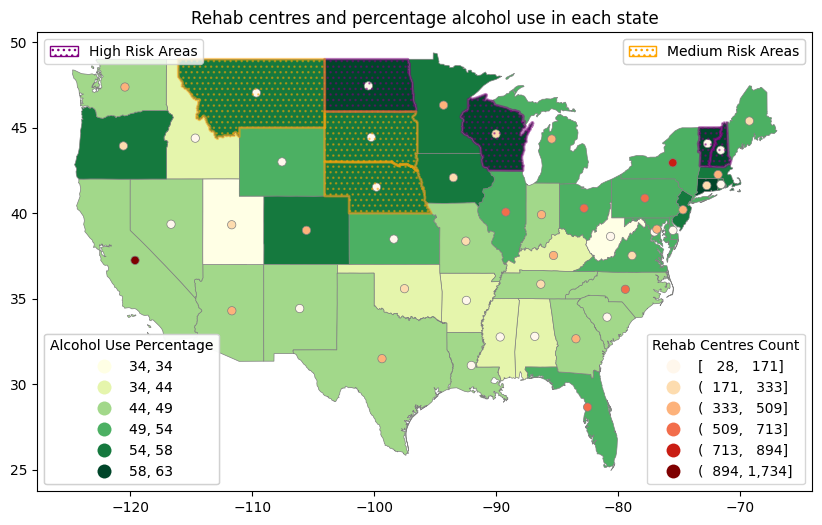

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,20))


ar_map.plot(ax= ax,column='Pop_based_count',legend=True,cmap='YlGn',scheme='natural_breaks',k=6, edgecolor='grey',
              linewidth=0.5,legend_kwds= {"fmt": "{:,.0f}","loc":"lower left"})
l1 = ax.get_legend()
l1.set_title('Alcohol Use Percentage')
ax.add_artist(l1)


rehabmap.plot(ax = ax,column='Count',legend=True,cmap='OrRd',scheme='natural_breaks',k=6, edgecolor='grey',
             linewidth=0.5,legend_kwds= {"fmt": "{:,.0f}", "interval": True,"loc":"lower right"})
l2 = ax.get_legend()
l2.set_title('Rehab Centres Count')
ax.add_artist(l2)

highrisk_map.plot(ax = ax,edgecolor='purple',linewidth=2, facecolor="none",alpha=0.5,hatch='...')
medrisk_map.plot(ax = ax,edgecolor='orange',linewidth=2, facecolor="none",alpha=0.5,hatch='...')

highrisk_patch = mpatches.Patch(edgecolor='purple', facecolor='none',
                     hatch='...', label=r'High Risk Areas')



medrisk_patch = mpatches.Patch(edgecolor='orange', facecolor='none',
                     hatch='...', label=r'Medium Risk Areas')

l3=plt.legend(handles=[highrisk_patch],loc='upper left')
l4=plt.legend(handles=[medrisk_patch],loc='upper right')

ax.title.set_text('Rehab centres and percentage alcohol use in each state')

ax.add_artist(l1)
ax.add_artist(l3)
ax.add_artist(l4)

plt.show()


### Map showing mental illness issues and treatment centres in each state

This map shows the count of total mental illness issues reported in each state and the total count of mental health treatment centres. States with high count of issues reported have a dark green gradient and states with high count of treatment centres have a dark red centroid.

In [ ]:
! wget -q -O treatment_data.csv 'https://github.com/gauravshetty98/Gaurav-GIS-Repo/raw/main/mental_health_treatment(1).csv'

ment_df = pd.read_csv('treatment_data.csv')
ment_df.head()

,Unnamed: 0,CASEID,LST,MHINTAKE,MHDIAGEVAL,MHREFERRAL,SMISEDSUD,TREATMT,ADMINSERV,SETTINGIP,...,OPLEGALTOTVOL,OPLEGALPERVOL,OPLEGALTOTNONFOREN,OPLEGALPERNONFOREN,OPLEGALTOTFOREN,OPLEGALPERFOREN,COD_PCT,TOTADMIS,PERCENTVA,Total Count
0,0,202000001,AK,1,1,1,1,1,0,0,...,1,-2,0,-2,1,-2,7,2,0,89
1,1,202000002,AK,1,1,1,1,1,1,0,...,1,-2,0,-2,1,-2,7,1,0,89
2,2,202000003,AK,1,1,1,1,1,0,0,...,1,7,0,0,0,0,7,6,0,89
3,3,202000004,AK,1,1,1,1,1,0,0,...,1,-2,0,-2,0,-2,7,5,0,89
4,4,202000005,AK,1,1,1,1,1,0,0,...,0,0,0,0,0,0,-2,-1,-1,89


In [ ]:
state = list(ment_df['LST'].unique())
count_df = pd.DataFrame(columns = ['State_Code', 'Count'])
for i in range(ment_df.shape[0]):
  if ment_df.iloc[i,2] in state:
    count_df.loc[len(count_df.index)] = [ment_df.iloc[i,2], ment_df.iloc[i,-1]]
    state.remove(ment_df.iloc[i,2])

In [ ]:
mt_map = pd.merge(mental_health_map, count_df, on = 'State_Code', how = 'inner', indicator = False)

In [ ]:
mt_map.shape

(49, 16)

In [ ]:
treatmentmap = mt_map[:]
treatmentmap['geometry'] = treatmentmap['geometry'].centroid

<ipython-input-70-62ced169f54c>:2: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




<Axes: >

<Axes: >

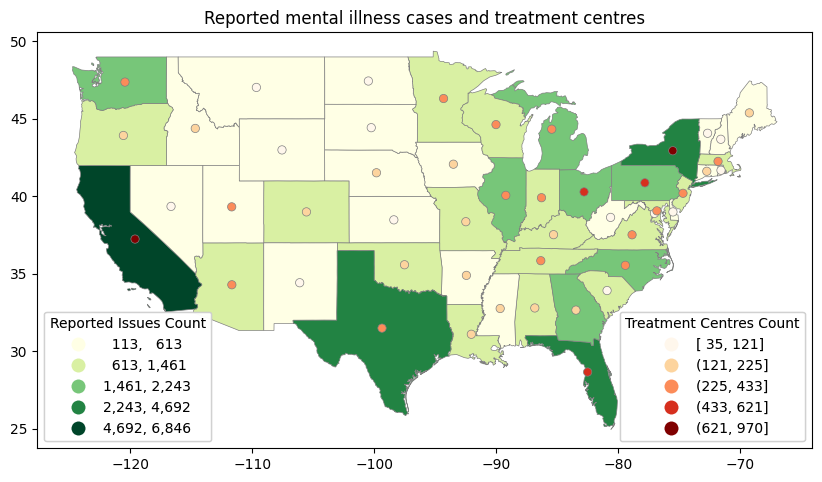

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,20))


mt_map.plot(ax= ax,column='18+',legend=True,cmap='YlGn',scheme='natural_breaks',k=5, edgecolor='grey',
              linewidth=0.5,legend_kwds= {"fmt": "{:,.0f}","loc":"lower left"})
l1 = ax.get_legend()
l1.set_title('Reported Issues Count')
ax.add_artist(l1)

treatmentmap.plot(ax = ax,column='Count',legend=True,cmap='OrRd',scheme='natural_breaks',k=5, edgecolor='grey',
             linewidth=0.5,legend_kwds= {"fmt": "{:,.0f}", "interval": True,"loc":"lower right"})
l2 = ax.get_legend()
l2.set_title('Treatment Centres Count')
ax.add_artist(l2)

# potrisk_map.plot(ax = ax,edgecolor='purple',linewidth=2, facecolor="none",alpha=0.4,hatch='...')

# potrisk_patch = mpatches.Patch(edgecolor='purple', facecolor='none',
#                      hatch='...', label=r'Areas with potential risk')
# l3=plt.legend(handles=[potrisk_patch],loc='upper right')

ax.title.set_text('Reported mental illness cases and treatment centres')

ax.add_artist(l1)
#ax.add_artist(l3)

plt.show()


### Map showing percentage of population with mental illness issues and treatment centres count

Similar to the above map we map reported issues with treatment centres, the only difference being we are considering the percentage of population with issues not the total count.

In [ ]:
mt_highrisk_map = mt_map.query("State_Code == 'MT' | State_Code == 'OR' ")
mt_medrisk_map = mt_map.query("State_Code == 'WY' | State_Code == 'ND' ")

<Axes: >

<Axes: >

<Axes: >

<Axes: >

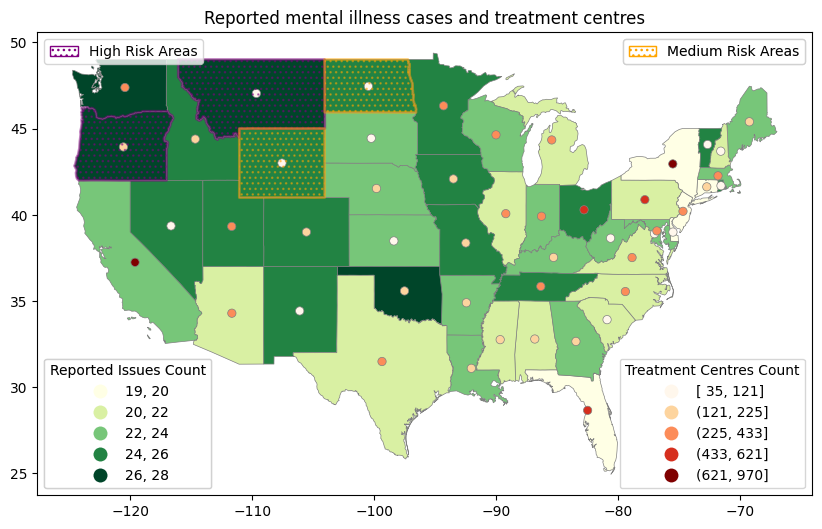

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,20))


mt_map.plot(ax= ax,column='Pop_based_count',legend=True,cmap='YlGn',scheme='natural_breaks',k=5, edgecolor='grey',
              linewidth=0.5,legend_kwds= {"fmt": "{:,.0f}","loc":"lower left"})
l1 = ax.get_legend()
l1.set_title('Reported Issues Count')
ax.add_artist(l1)

treatmentmap.plot(ax = ax,column='Count',legend=True,cmap='OrRd',scheme='natural_breaks',k=5, edgecolor='grey',
             linewidth=0.5,legend_kwds= {"fmt": "{:,.0f}", "interval": True,"loc":"lower right"})
l2 = ax.get_legend()
l2.set_title('Treatment Centres Count')
ax.add_artist(l2)

mt_highrisk_map.plot(ax = ax,edgecolor='purple',linewidth=2, facecolor="none",alpha=0.5,hatch='...')
mt_medrisk_map.plot(ax = ax,edgecolor='orange',linewidth=2, facecolor="none",alpha=0.5,hatch='...')

mt_highrisk_patch = mpatches.Patch(edgecolor='purple', facecolor='none',
                     hatch='...', label=r'High Risk Areas')



mt_medrisk_patch = mpatches.Patch(edgecolor='orange', facecolor='none',
                     hatch='...', label=r'Medium Risk Areas')

l3=plt.legend(handles=[mt_highrisk_patch],loc='upper left')
l4=plt.legend(handles=[mt_medrisk_patch],loc='upper right')

ax.title.set_text('Reported mental illness cases and treatment centres')

ax.add_artist(l1)
ax.add_artist(l3)
ax.add_artist(l4)

plt.show()


In [ ]:
!wget -q -O rehab_dir.csv 'https://github.com/gauravshetty98/Gaurav-GIS-Repo/raw/main/rehab_dir_lat_long5.csv'

In [ ]:
rehab_dir = pd.read_csv('rehab_dir.csv')
rehab_dir.head(1)

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/colab/data_table.py", line 202, in _repr_javascript_module_
    return self._gen_js(self._preprocess_dataframe())
  File "/usr/local/lib/python3.10/dist-packages/google/colab/data_table.py", line 178, in _preprocess_dataframe
    dataframe = dataframe.reset_index()
  File "/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py", line 331, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/frame.py", line 6361, in reset_index
    new_obj.insert(
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/frame.py", line 4817, in insert
    raise ValueError(f"cannot insert {column}, already exists")
ValueError: cannot insert level_0, already exists


,Unnamed: 0,level_0,index,Name1,Name2,Street1,Street2,City,State,Zip,Phone,Intake1,Intake2,Intake1a,Intake2a,Service_code_info,lat,long
0,0,0,0,Shelby County Treatment Center,NaN,750 Highway 31 South,NaN,Alabaster,AL,35007,205-216-0200,NaN,NaN,NaN,NaN,SA DT SUMH * OP OD OIT OMB ORT * MU BU NU * PM...,33.234126,-86.816268


In [ ]:
geometry = [Point(xy) for xy in zip(rehab_dir['long'], rehab_dir['lat'])]
geo_df = gpd.GeoDataFrame(geometry = geometry[:])

<Axes: >

',legend_kwds= {"fmt": "{:,.0f}","loc":"lower left"}'

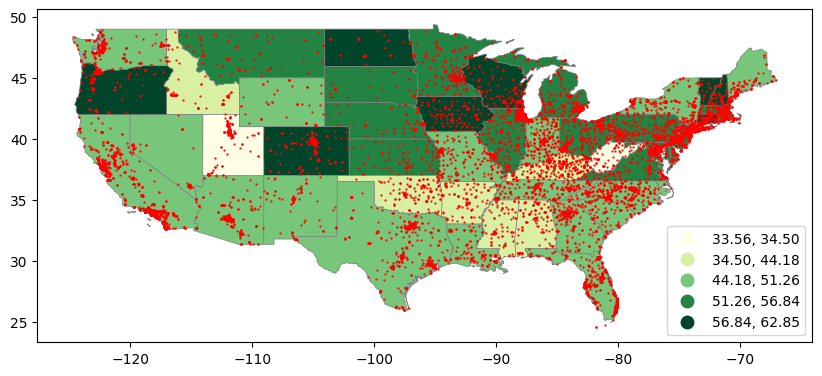

In [ ]:
fig, ax = plt.subplots(figsize=(10,15))

ar_map.plot(ax= ax,column='Pop_based_count',legend=True,cmap='YlGn',scheme='natural_breaks',k=5, edgecolor='grey',
              linewidth=0.5)

''',legend_kwds= {"fmt": "{:,.0f}","loc":"lower left"}'''
#l1 = ax.get_legend()
#l1.set_title('Alcohol Use Count')
#ax.add_artist(l1)

g = geo_df.plot(ax = ax, markersize = 1.4, color = 'red',marker = '.')

plt.show()

In [ ]:
!wget -q -O mh_dir.csv 'https://github.com/gauravshetty98/Gaurav-GIS-Repo/raw/main/mental_health_centers2.csv'

In [ ]:
mh_dir = pd.read_csv('mh_dir.csv')
mh_dir.head(1)

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/colab/data_table.py", line 202, in _repr_javascript_module_
    return self._gen_js(self._preprocess_dataframe())
  File "/usr/local/lib/python3.10/dist-packages/google/colab/data_table.py", line 178, in _preprocess_dataframe
    dataframe = dataframe.reset_index()
  File "/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py", line 331, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/frame.py", line 6361, in reset_index
    new_obj.insert(
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/frame.py", line 4817, in insert
    raise ValueError(f"cannot insert {column}, already exists")
ValueError: cannot insert level_0, already exists


,Unnamed: 0,level_0,index,Name1,Name2,Street1,Street2,City,State,Zip,Phone,Intake1,Intake2,Intake1a,Intake2a,Service_code_info,lat,long
0,0,0,0,SpectraCare Health Systems,Henry County Clinic,219 Dothan Road,NaN,Abbeville,AL,36310,800-951-4357,NaN,NaN,NaN,NaN,SA MH SUMH * OP * CMHC * CHLOR FLUPH HALOP PER...,31.573584,-85.234008


In [ ]:
geometry = [Point(xy) for xy in zip(mh_dir['long'], mh_dir['lat'])]
geo_df = gpd.GeoDataFrame(geometry = geometry[:])

<Axes: >

',legend_kwds= {"fmt": "{:,.0f}","loc":"lower left"}'

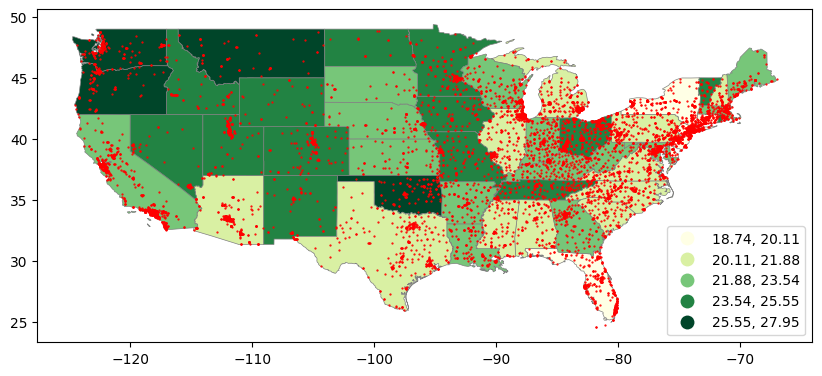

In [ ]:
fig, ax = plt.subplots(figsize=(10,15))

mt_map.plot(ax= ax,column='Pop_based_count',legend=True,cmap='YlGn',scheme='natural_breaks',k=5, edgecolor='grey',
              linewidth=0.5)

''',legend_kwds= {"fmt": "{:,.0f}","loc":"lower left"}'''
#l1 = ax.get_legend()
#l1.set_title('Alcohol Use Count')
#ax.add_artist(l1)

g = geo_df.plot(ax = ax, markersize = 1.4, color = 'red',marker = '.')

plt.show()